## WOT Preprocessing and Computation

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata
import scipy.stats 
import wot
import math
from matplotlib.lines import Line2D
import ipywidgets as widgets

In [55]:
ADATA_PATH = 'data/wot_input.h5ad'
GROWTH_PATH = 'data/growth-rates.csv'
CELLWALL_PATH = 'data/cell-wall-genes.txt'
COMMON_NAMES = 'data/common-names.csv'

OUTPUT_PATH = 'output/wot/'
TMAP_PATH = 'output/wot/tmaps/'

### Data Preprocessing

#### Assign Growth Rates

In [4]:
# Load the anndata and growth rates
adata = anndata.read_h5ad(ADATA_PATH)
growth_rates = pd.read_csv(GROWTH_PATH, index_col=0)

In [5]:
# Add an initial growth rate column based on Rahni and Birnbaum (2019), where cells in the proliferation domain/
# proximal root  tip divide according to the observed rate while cells outside the proliferation domain/proximal 
# root tip simply persist
def simple_growth(cell):
    if cell['dev_stage'] not in ['Proliferation Domain', 'Proximal Lateral Root Cap', 'Proximal Columella']:
        return 1
    else:
        return growth_rates.loc[cell.celltype, 'Mean_Daily_Growth_Rate']
    
adata.obs['init_growth'] = adata.obs.apply(simple_growth, axis=1)

In [6]:
# Add a column to obs calculating the time to the next timepoint, or 0 if it is the last timepoint
adata.obs['exp_time'] = adata.obs['exp_time'].apply(lambda x: float(x))
times = list(pd.unique(adata.obs['exp_time']))
times.sort()

def calc_delta_t(t):
    idx = times.index(t)
    if idx == len(times) - 1:
        return 0
    else:
        return (times[idx+1] - times[idx])/24

adata.obs['delta_t'] = adata.obs['exp_time'].apply(calc_delta_t)
adata.obs.delta_t.value_counts()

0.020833    20804
0.083333    12485
0.166667     6907
0.000000     6389
0.041667     6336
Name: delta_t, dtype: int64

In [7]:
# Calculate the proportion of cells for each celltype by zone
count_df = adata.obs.groupby(['celltype', 'dev_stage']).size().reset_index()
count_df.rename(columns={0: 'n'}, inplace=True)
zone_props = pd.pivot_table(count_df, index='celltype', columns='dev_stage', values='n')
zone_props = zone_props.div(zone_props.sum(axis=1), axis=0)
zone_props.columns = list(zone_props.columns)
zone_props

,Distal Columella,Distal Lateral Root Cap,Elongation,Maturation,Proliferation Domain,Proximal Columella,Proximal Lateral Root Cap,Transition Domain
celltype,,,,,,,,
Atrichoblast,0.000000,0.000000,0.308023,0.221837,0.311625,0.000000,0.000000,0.158515
Columella,0.837963,0.000000,0.000000,0.000000,0.000000,0.162037,0.000000,0.000000
Cortex,0.000000,0.000000,0.580359,0.094938,0.056216,0.000000,0.000000,0.268486
Endodermis,0.000000,0.000000,0.588356,0.339848,0.068504,0.000000,0.000000,0.003292
Lateral Root Cap,0.000000,0.250286,0.000000,0.000000,0.000000,0.000000,0.749714,0.000000
Pericycle,0.000000,0.000000,0.855275,0.107510,0.010938,0.000000,0.000000,0.026277
Phloem,0.000000,0.000000,0.785373,0.064054,0.013862,0.000000,0.000000,0.136711
Procambium,0.000000,0.000000,0.884263,0.109389,0.000295,0.000000,0.000000,0.006053
Quiescent Center,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


In [8]:
# Helper functions to get the growth and terminal zones associated with each lineage
def growth_zone(lin):
    if lin == 'Columella':
        return 'Proximal Columella'
    elif lin == 'Lateral Root Cap':
        return 'Proximal Lateral Root Cap'
    else:
        return 'Proliferation Domain'
        
def terminal_zone(lin):
    if lin == 'Columella':
        return 'Distal Columella'
    elif lin == 'Lateral Root Cap':
        return 'Distal Lateral Root Cap'
    else:
        return 'Proliferation Domain'

In [9]:
# Modify the simple growth column by finding the proportion of cells from each lineage 
# that would be expected to leave the 0.5cm section of root that was sequenced before the 
# next timepoint and set those growth rates to ~0. 

def remove_leaving_cells(cell):
    # Calculate the proportion of this cell's lineage leaving before the next time as the proportion of 
    # cells in the meristem/proximal root tip times the proportion of daily growth to the interval of time
    lin = cell['celltype']
    if lin != 'Quiescent Center':
        prop_exit = zone_props.loc[lin, growth_zone(lin)] * (growth_rates.Mean_Daily_Growth_Rate[lin]**cell['delta_t'] - 1)
        if cell['pseudotime_perc'] >= 1 - prop_exit:
            return 0.0001 # WOT throws an error if a growth rate is set identically to 0
    # Otherwise return the old growth value, converted to growth per hour
    return cell['init_growth']
    
adata.obs['growth_day'] = adata.obs.apply(remove_leaving_cells, axis=1)

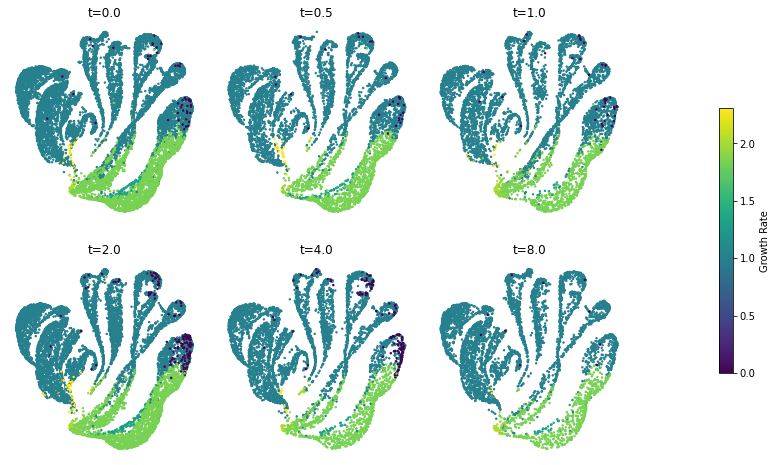

In [10]:
# Visualize growth rates
fig = plt.figure(figsize=(13,8))
gs = fig.add_gridspec(2, 7)
col = 0
row = 0
for time in times:
    plt.subplot(gs[row,2*col:2*(col+1)])
    col = col + 1
    if col == 3:
        row = row + 1
        col = 0
    data = adata.obs[(adata.obs['exp_time'] == time)]
    plt.scatter(data.umap_x, data.umap_y, c=data['growth_day'], s=2, vmin=0)
    plt.axis('off')
    plt.title('t={}'.format(time))

plt.subplot(gs[:,6])
plt.axis('off')
plt.colorbar(label='Growth Rate')
plt.show()

In [11]:
# Convert the growth rate to growth per hour
adata.obs['growth_hr'] = adata.obs['growth_day']**(1/24)

#### Score for Cell Wall Genes

In [12]:
# Load the genes and check they are present in the data
genes = pd.read_csv(CELLWALL_PATH, header=None, names=['gene'])
adata.var['gene'] = adata.var.index
print("{}/{} genes present in the data".format(len(set(adata.var.gene) & set(genes.gene)) , len(set(genes.gene))))

107/107 genes present in the data


In [13]:
# Create an anndata object with a binary vector for each gene signature to pass to the wot
# gene signature scoring function
gene_sig_binary = np.array([adata.var['gene'].apply(lambda x: 1 if x in list(genes.gene) else 0)]).T

gs = anndata.AnnData(X=gene_sig_binary, obs=adata.var, var=pd.DataFrame({'sig': ['cell_wall']}).set_index('sig'))

In [14]:
# Calculate the signature score and add it to obs
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    adata.obs[gene_set_name] = result['score']

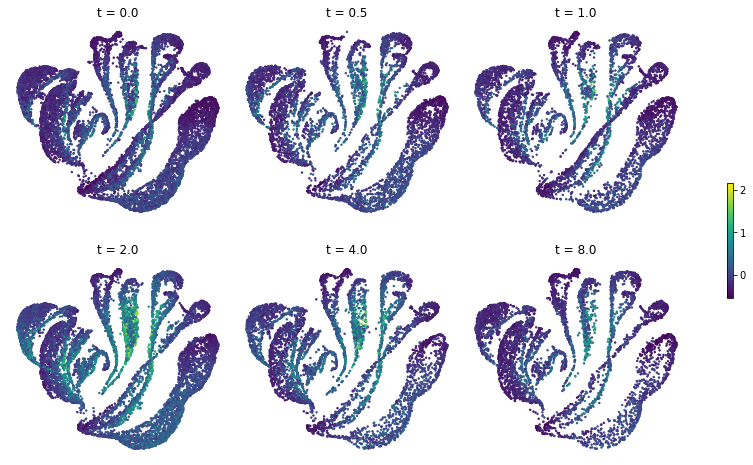

In [15]:
# Visualize the cell wall score
fig = plt.figure(figsize=(13,8))
gs = fig.add_gridspec(2,16)
curr_col = 0
curr_row = 0
for t in pd.unique(adata.obs['exp_time']):
    plt.subplot(gs[curr_row, 5*curr_col:5*(curr_col+1)])
    if curr_col == 2:
        curr_col = 0
        curr_row = curr_row + 1
    else:
        curr_col = curr_col + 1
    plt.title('t = {}'.format(t))
    plt.scatter(adata.obs[adata.obs['exp_time'] == t].umap_x, 
                adata.obs[adata.obs['exp_time'] == t].umap_y, 
                s=2, c=adata.obs[adata.obs['exp_time'] == t].cell_wall,
                vmax=np.percentile(max(adata.obs.cell_wall), 95), vmin=min(adata.obs.cell_wall))
    plt.axis('off')
    
plt.subplot(gs[:,15:])
plt.axis('off')
plt.clim(min(adata.obs.cell_wall), np.percentile(max(adata.obs.cell_wall), 95))
plt.colorbar()
plt.show()

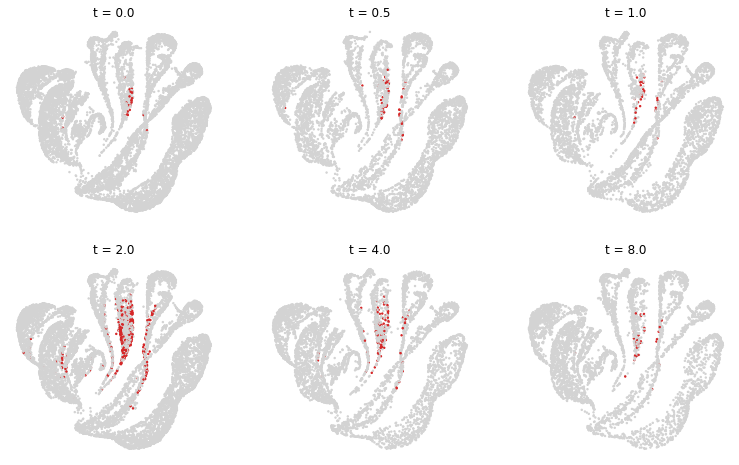

In [17]:
# Visualize all cells with a cell wall score above the threshold of 1
thresh = 1
fig = plt.figure(figsize=(13,8))
curr_plot = 1
for t in pd.unique(adata.obs['exp_time']):
    plt.subplot(2,3,curr_plot)
    plt.title('t = {}'.format(t))
    curr_plot = curr_plot + 1
    plt.scatter(adata.obs[adata.obs['exp_time'] == t].umap_x, 
                adata.obs[adata.obs['exp_time'] == t].umap_y, 
                s=2, c=adata.obs[adata.obs['exp_time'] == t].cell_wall.apply(lambda x: 'tab:red' if x > thresh else 'lightgrey'))
    plt.axis('off')
plt.show()

### Calculate Transport Maps, Trajectories, and Fates

In [ ]:
# Specify the ot model
ot_model = wot.ot.OTModel(adata, day_field = 'exp_time', growth_rate_field='growth_hr', epsilon = 0.05, 
                          lambda1= 1, lambda2= 50, growth_iters = 1)

In [ ]:
# Compute all of the transport maps
ot_model.compute_all_transport_maps(tmap_out=TMAP_PATH)

In [18]:
# Load the tmap model and produce trajectories
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)

In [24]:
# Create cell sets for visualization
types = list(pd.unique(adata.obs['celltype']))
zones = list(pd.unique(adata.obs['dev_stage']))
types.sort()

cell_sets = {}
cell_zone_sets = {}

for t in types:
    cell_sets[t] = list(adata.obs.index[adata.obs['celltype'] == t])
    if t == 'Cortex':
        cell_sets['Cortex +'] = list(adata.obs.index[(adata.obs['celltype'] == t) & (adata.obs['cell_wall'] >= 1)])
        cell_sets['Cortex -'] = list(adata.obs.index[(adata.obs['celltype'] == t) & (adata.obs['cell_wall'] < 1)])
    for z in zones:
        cell_zone_sets["{}-{}".format(z,t)] = list(adata.obs.index[(adata.obs['celltype'] == t) & (adata.obs['dev_stage'] == z)])
        if t == 'Cortex':
            cell_zone_sets['{}-Cortex +'.format(z)] = list(adata.obs.index[(adata.obs['celltype'] == t) & (adata.obs['cell_wall'] >= 1) & (adata.obs['dev_stage'] == z)])
            cell_zone_sets['{}-Cortex -'.format(z)] = list(adata.obs.index[(adata.obs['celltype'] == t) & (adata.obs['cell_wall'] < 1) & (adata.obs['dev_stage'] == z)])
    
# Remove the cortex cell set for the fate calculations
fates_cell_sets = cell_sets.copy()
fates_cell_sets.pop('Cortex')
    
# Create tissue sets
tissues = pd.unique(adata.obs['tissue'])
tissue_sets = {}

for t in tissues:
    tissue_sets[t] = list(adata.obs.index[adata.obs['tissue'] == t])   

In [52]:
# Precompute trajectories, trends, and fates for every time
times = pd.unique(adata.obs['exp_time'])
time = 2 # Reference time

# Load common gene names
common_names = pd.read_csv(COMMON_NAMES, index_col=0)

# Load the tmap model and produce trajectories
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)

type_populations = tmap_model.population_from_cell_sets(cell_sets, at_time=time)
type_trajectory_ds = tmap_model.trajectories(type_populations)

typezone_populations = tmap_model.population_from_cell_sets(cell_zone_sets, at_time=time)
typezone_trajectory_ds = tmap_model.trajectories(typezone_populations)

tissue_populations = tmap_model.population_from_cell_sets(tissue_sets, at_time=time)
tissue_trajectory_ds = tmap_model.trajectories(tissue_populations)

# Join the metadata to the trajectory data
type_trajectory_ds.obs = type_trajectory_ds.obs.join(adata.obs)
typezone_trajectory_ds.obs = typezone_trajectory_ds.obs.join(adata.obs)
tissue_trajectory_ds.obs = tissue_trajectory_ds.obs.join(adata.obs)

# Save the trajectories
type_trajectory_ds.write_h5ad(OUTPUT_PATH + 'type_trajectories_T={}.h5ad'.format(time))
typezone_trajectory_ds.write_h5ad(OUTPUT_PATH + 'typezone_trajectories_T={}.h5ad'.format(time))
tissue_trajectory_ds.write_h5ad(OUTPUT_PATH + 'tissue_trajectories_T={}.h5ad'.format(time))
print('\tFinished trajectories')

# Compute trends by tissue type
tissue_trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(tissue_trajectory_ds, adata)
for i in range(len(tissue_trajectory_trends)):
    data = tissue_trajectory_trends[i]
    data.var = data.var.join(common_names)
    data.write(filename = OUTPUT_PATH + "trends/T={}-{}_trends.h5ad".format(time, tissue_trajectory_ds.var.index[i]), compression = 'gzip')
print('\tFinished tissue trends')

# Compute trends by celltype
type_trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(type_trajectory_ds, adata)
for i in range(len(type_trajectory_trends)):
    data = type_trajectory_trends[i]
    data.var = data.var.join(common_names)
    data.write(filename = OUTPUT_PATH + "trends/T={}-{}_trends.h5ad".format(time, type_trajectory_ds.var.index[i]), compression = 'gzip')
print('\tFinished celltype trends')

# Calculate fates
target_destinations = tmap_model.population_from_cell_sets(fates_cell_sets, at_time=time)
fate_ds = tmap_model.fates(target_destinations)
fate_ds.obs = fate_ds.obs.join(adata.obs)
fate_ds.write_h5ad(OUTPUT_PATH + "fate-adata-T={}.h5ad".format(time))
print('\tFinished fates')

	Finished trajectories


/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical


	Finished tissue trends


... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical
... storing 'Name' as categorical


	Finished celltype trends
	Finished fates


### Compute Differential Expression

In [ ]:
# Precompute differential expression results
times = pd.unique(adata.obs['exp_time'])
diff_exp_results = {}
fates = {}

# Load common gene names
common_names = pd.read_csv(COMMON_NAMES, index_col=0)

# Alternate fraction expressed ratio function
def adj_exp_ratio(result, adj=0.1):
    min_exp = min(result.fraction_expressed1, result.fraction_expressed2)
    max_exp = max(result.fraction_expressed1, result.fraction_expressed2)
    return max_exp/(min_exp + adj)
   
target_destinations = tmap_model.population_from_cell_sets(fates_cell_sets, at_time=time)

# Create a fates anndata, adding a cortex fate as the sum of cortex + and - fates
# Note that each row sum now exceeds 1.
fate_ds = tmap_model.fates(target_destinations)

var_idx = list(fate_ds.var.index)
idx_cp = var_idx.index('Cortex +')
idx_cm = var_idx.index('Cortex -')

X = fate_ds.X
Y = np.zeros((X.shape[0], X.shape[1] + 1))
Y[:,:-1] = X
Y[:,-1] = Y[:,idx_cp] + Y[:,idx_cm]

var_idx.append('Cortex')

fates[time] = anndata.AnnData(obs=fate_ds.obs, var = pd.DataFrame(index=var_idx), X=Y)

for t in list(fates[time].var.index):
    results = wot.tmap.diff_exp(adata, fates[time], cell_days_field='exp_time', compare=t)
    results['fraction_expressed_ratio'] = results.apply(lambda result: adj_exp_ratio(result), axis=1)
    diff_exp_results[t] = results
    diff_exp_results[t] = diff_exp_results[t].join(common_names)
    diff_exp_results[t] = diff_exp_results[t].rename(columns={'Name': 'Common Name',
                                                              'day1': 'Time',
                                                              'name2': 'Comparison Type', 
                                                              'mean1': '{} Exp. Mean'.format(t), 
                                                              'mean2': 'Comparison Exp. Mean', 
                                                              'fraction_expressed1': '{} Prop. Exp.'.format(t), 
                                                              'fraction_expressed2': 'Comparison Prop. Exp.', 
                                                              'fraction_expressed_ratio': 'Expression Ratio', 
                                                              'timepoint': 'Time Point'})
    diff_exp_results[t]['gene'] = diff_exp_results[t].index
    diff_exp_results[t]['TF'] = diff_exp_results[t]['gene'].apply(lambda x: x in tfs)

    diff_exp_results[t].to_csv(OUTPUT_PATH + "diff-exp/diff-exp-T={}-{}.csv".format(time, t))
    print('\tFinished {}'.format(t))

	Finished Atrichoblast
	Finished Columella
	Finished Cortex +
	Finished Cortex -
	Finished Endodermis
	Finished Lateral Root Cap
